In [1]:
from tqdm.notebook import tqdm
import numpy as np
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
from short_hf import ShortHFModel

from transformers.utils import logging

# logging.set_verbosity_info()
# logger = logging.get_logger("transformers")
# logger.info("INFO")
# logger.warning("WARN")

# TOKENIZERS_PARALLELISM
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings("ignore")

def format_mmlu_prompt(question, choices):
    """Format MMLU question into a prompt for the model"""
    prompt = f"Question: {question}\n"
    for i, choice in enumerate(choices):
        prompt += f"{chr(65+i)}. {choice}\n"
    prompt += "Answer:"
    return prompt

# def evaluate_mmlu_accuracy(model, dataloader):
#     """Evaluate model accuracy on MMLU before/after pruning"""
#     correct = 0
#     total = 0
    
#     with torch.no_grad():
#         for i, batch in enumerate(tqdm(dataloader, desc="Evaluating")):                
#             for j in range(len(batch['question'])):
#                 question = batch['question'][j]
#                 choices = batch['choices'][j]
#                 answer_idx = batch['answer'][j].item()
                
#                 # Format the prompt
#                 prompt = format_mmlu_prompt(question, choices)
                
#                 # Tokenize
#                 inputs = model.tokenizer(prompt, return_tensors="pt", padding=True)
#                 input_ids = inputs.input_ids.to("cuda")
                
#                 # Generate only 1 token (should be A, B, C, or D)
#                 outputs = model.model.generate(
#                     input_ids=input_ids,
#                     max_new_tokens=1,
#                     temperature=0.6,
#                     do_sample=True,
#                     top_p=0.9,
#                     pad_token_id=model.tokenizer.eos_token_id
#                 )
                
#                 # Get the generated token
#                 generated_token_id = outputs[0, -1].item()
#                 generated_text = model.tokenizer.decode(generated_token_id)
                
#                 # Check if correct (A=0, B=1, C=2, D=3)
#                 if generated_text.strip().upper() == chr(65 + answer_idx):
#                     correct += 1
#                 total += 1
    
#     accuracy = correct / total if total > 0 else 0
#     return accuracy, total
def evaluate_mmlu_accuracy(model, dataloader):
    choice_tokens = [model.tokenizer.encode(f" {c}", add_special_tokens=False)[0] for c in "ABCD"]

    correct = total = 0
    for batch in tqdm(dataloader, desc="Evaluating"):
        for q, choices, ans in zip(batch['question'],
                                   batch['choices'],
                                   batch['answer']):
            prompt = format_mmlu_prompt(q, choices)
            inputs = model.tokenizer(prompt, return_tensors="pt").to("cuda")

            with torch.inference_mode():
                out = model.model(**inputs)
                logits = out.logits[0, -1]                     # (V,)

            # ① 4개 후보 로짓만 추출
            logits_subset = logits[choice_tokens]              # (4,)

            # ② GPU 상에서 argmax → .item()
            pred_letter = int(torch.argmax(logits_subset).item())   # 0~3

            if pred_letter == ans.item():
                correct += 1
            total += 1

    return correct / total if total else 0, total


# Load MMLU dataset
print("Loading MMLU dataset...")
data = load_dataset("cais/mmlu", "all", split="test")  # Use test split for evaluation

# Create custom collate function for MMLU
def collate_fn(batch):
    return {
        'question': [item['question'] for item in batch],
        'choices': [item['choices'] for item in batch],
        'answer': torch.tensor([item['answer'] for item in batch]),
        'subject': [item['subject'] for item in batch]
    }

# Create dataloaders
eval_dataloader = DataLoader(
    data,
    batch_size=8,  # Smaller batch size for evaluation
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=4
)

# For importance computation, we'll use a subset and format as prompts
importance_data = data
importance_prompts = []
for item in tqdm(importance_data, desc="Formatting prompts"):
    prompt = format_mmlu_prompt(item['question'], item['choices'])
    # Add the correct answer to make it more like training data
    prompt += f" {chr(65 + item['answer'])}"
    importance_prompts.append(prompt)

layer_repeat_config = {
    # 10: 2,  # Repeat layer 10 twice
    10: 2
}
# Initialize model
MAX_SEQ_LEN = 1024
print("Initializing model...")
short_model = ShortHFModel(
    model_name="/workspace/Llama-3.2-1B-depth-scaling-mmlu", ##################################################
    layers_path="model.layers",
    # layer_repeat_config=layer_repeat_config
    # n_prune_layers=9
)

# # Evaluate before pruning
# print("\n=== Evaluating model BEFORE pruning ===")
# accuracy_before, n_samples = evaluate_mmlu_accuracy(short_model, eval_dataloader)
# print(f"Accuracy before pruning: {accuracy_before:.2%} (on {n_samples} samples)")

# # Compute importance scores
# print("\n=== Computing importance scores ===")
# batch_size = 32
# for i in tqdm(range(0, len(importance_prompts), batch_size), desc="Computing importance"):
#     batch_prompts = importance_prompts[i:i+batch_size]
    
#     short_model.eval_importance(
#         prompts=batch_prompts,
#         max_seq_len=MAX_SEQ_LEN,
#         stride=256,
#         max_gen_len=0,
#         angular=False  # Set to True if you want to use angular distance
#     )

# # Print importance scores
# print("\nLayer importance scores:")
# for i, score in enumerate(short_model.importances):
#     print(f"Layer {i}: {score:.4f}")

# # Remove layers
# print(f"\n=== Removing {short_model.n_prune_layers} layers ===")
# removed_layers = short_model.remove_layers()
# print(f"Removed layers: {removed_layers}")

# # Update layer indices after pruning
# for layer_idx, module in enumerate(short_model.layers):
#     module.self_attn.layer_idx = layer_idx

# Evaluate after pruning
print("\n=== Evaluating model AFTER pruning ===")
accuracy_after, n_samples = evaluate_mmlu_accuracy(short_model, eval_dataloader)
print(f"Accuracy after pruning: {accuracy_after:.2%} (on {n_samples} samples)")

# # Print performance drop
# print(f"\nPerformance drop: {accuracy_before - accuracy_after:.2%}")
# print(f"Relative performance retained: {(accuracy_after/accuracy_before)*100:.1f}%")

# # Save the pruned model
# print("\n=== Saving pruned model ===")
# save_path = "/workspace/Llama-3.2-3B-depth-scaling-mmlu" ##################################################
# short_model.model.save_pretrained(save_path)
# short_model.tokenizer.save_pretrained(save_path)
# print(f"Model saved to {save_path}")

# # Optional: Save pruning statistics
# import json
# stats = {
#     "original_layers": len(short_model.importances),
#     "removed_layers": removed_layers,
#     "n_prune_layers": short_model.n_prune_layers,
#     "accuracy_before": accuracy_before,
#     "accuracy_after": accuracy_after,
#     "performance_drop": accuracy_before - accuracy_after,
#     "importance_scores": short_model.importances
# }

# with open(f"{save_path}/pruning_stats.json", "w") as f:
#     json.dump(stats, f, indent=2)
# print("Pruning statistics saved!")

Loading MMLU dataset...


Formatting prompts:   0%|          | 0/14042 [00:00<?, ?it/s]

Initializing model...


Some weights of LlamaForCausalLM were not initialized from the model checkpoint at /workspace/Llama-3.2-1B-depth-scaling-mmlu and are newly initialized: ['model.layers.12.input_layernorm.weight', 'model.layers.12.mlp.down_proj.weight', 'model.layers.12.mlp.gate_proj.weight', 'model.layers.12.mlp.up_proj.weight', 'model.layers.12.post_attention_layernorm.weight', 'model.layers.12.self_attn.k_proj.weight', 'model.layers.12.self_attn.o_proj.weight', 'model.layers.12.self_attn.q_proj.weight', 'model.layers.12.self_attn.v_proj.weight', 'model.layers.13.input_layernorm.weight', 'model.layers.13.mlp.down_proj.weight', 'model.layers.13.mlp.gate_proj.weight', 'model.layers.13.mlp.up_proj.weight', 'model.layers.13.post_attention_layernorm.weight', 'model.layers.13.self_attn.k_proj.weight', 'model.layers.13.self_attn.o_proj.weight', 'model.layers.13.self_attn.q_proj.weight', 'model.layers.13.self_attn.v_proj.weight', 'model.layers.14.input_layernorm.weight', 'model.layers.14.mlp.down_proj.weight'

n_prune_layers: 4

=== Evaluating model AFTER pruning ===


Evaluating:   0%|          | 0/1756 [00:00<?, ?it/s]

Accuracy after pruning: 27.23% (on 14042 samples)


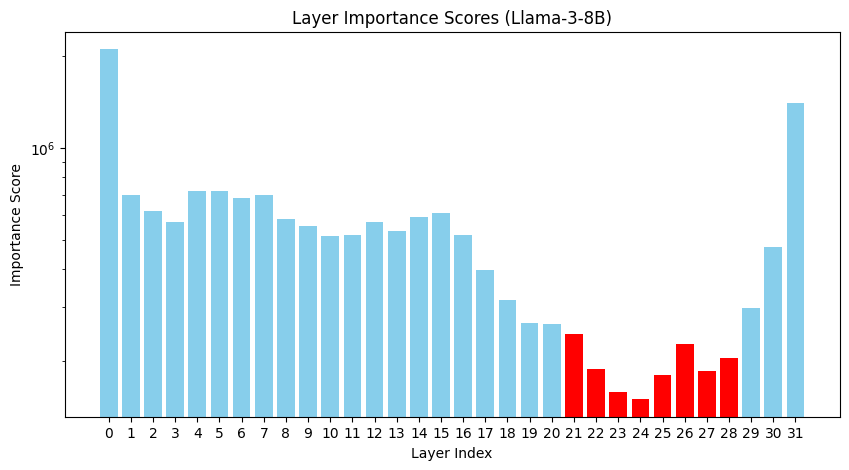

In [4]:
import matplotlib.pyplot as plt
import json

with open("/workspace/Llama-3-8B-depth-scaling-mmlu/pruning_stats.json", "r") as f:
    stats = json.load(f)

importance_scores = stats["importance_scores"]
removed_layers = stats["removed_layers"]

# Create a bar plot of importance scores and highlight the removed layers
plt.figure(figsize=(10, 5))
plt.bar(range(len(stats["importance_scores"])), stats["importance_scores"], color='skyblue')

# Highlight the removed layers
for i in removed_layers:
    plt.bar(i, importance_scores[i], color='red')

# x축에 1 증가하는 값을 표시
plt.xticks(range(len(importance_scores)), [f"{i}" for i in range(len(importance_scores))])

plt.xlabel('Layer Index')
plt.ylabel('Importance Score')
plt.title('Layer Importance Scores (Llama-3-8B)')
plt.yscale('log')
plt.show()